<a href="https://colab.research.google.com/github/GeraldShin/PyTorch-Debut/blob/master/PyTorch_Debut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install --trusted-host download.pytorch.org torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

#actually it looks like this is now native in Colab, so we don't even have to pip it in anymore

In [0]:
import torch
import torchvision 
#these are the standard modules for PyTorch

import torch.nn as nn 
import torch.nn.functional as F
import torchvision.transforms as transforms 
#import torch.optim - we won't use this one in this tutorial (has like SGD and Adam optimizers)
#these are the modules that are more commonly used in Machine learning applications 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#these are obv

Because this is a "Hello World" introduction into PyTorch, we're going to be using the infamous MNIST dataset. 

PyTorch has a function called DataLoader which will efficiently build batches and feed in the data in subsets. You can set the size of the batch, typically you see 32/64.

FYI: In the context of machine learning, a tensor is a type of data structure that is highly efficient. 

In [0]:
BATCH_SIZE = 32

transform = transforms.Compose( #This is a list of transformations to apply to the data
    [transforms.ToTensor()]
)

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform) #this will import the data from the datasets built into PyTorch and then apply the transformations to it

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, #reminder: this will load the dataset into the workspace into tensors
                                          shuffle=True, num_workers=2) 

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2) 

In [4]:
print(trainset)

print(testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


**Taking a closer look at the transforms.Compose() function**

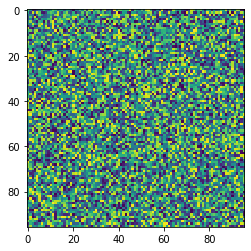

In [5]:
image = transforms.ToPILImage(mode='L')(torch.randn(1, 96, 96))  #this is going to just generate a random image 

plt.imshow(image)

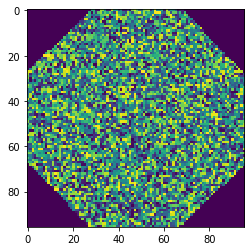

In [6]:
example_transform = transforms.Compose(
    [transforms.RandomRotation(45, fill=(0,)),
     transforms.RandomVerticalFlip()]
    )

example_result = example_transform(image)

plt.imshow(example_result)

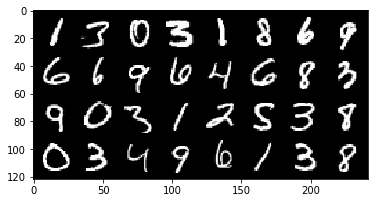

In [7]:
def imshow(img):
  #img = img / 2 + 0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
#function to convert the tensor to a numpy array, stack the array using transpose, and then visualize that numpy array

## get randomized training imgs from training dataset
dataiter = iter(trainloader)
images, labels = dataiter.next()


## show images
imshow(torchvision.utils.make_grid(images))

In [8]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape) #believe this means there are 32, 28x28 images?
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


A standard convention for buildling a neural network in PyTorch is to create a class that houses the model. We will call it 'MyModel'

In [0]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = nn.Linear(28 * 28, 128) #first hidden layer
    self.dropout = nn.Dropout(p=0.2) #drop out layer
    self.d2 = nn.Linear(128, 10) #final, output layer

  def forward(self, x):
    x = x.flatten(start_dim = 1)
    x = self.d1(x)
    x = F.relu(x)
    x = self.dropout(x)
    logits = self.d2(x)
    out = F.softmax(logits, dim=1)
    return out

  


**Calls** to the Linear function in the neural net package will create a **dense layer** which has the following requirements
```
nn.Linear(in, out)
self.d1 = nn.Linear(28 * 28, 128)
self.d2 = nn.Linear(128, 10)
```


*   In dimensions - These are the dimensions that going in as an input
*   Out dimensions - These are the dimensions getting passed out

Notice that the output for the first layer must match the input for the second layer.  
Also notice that the final output layer is 10 variables wide, one for each digit we're going to estimate.

**Dropout Layers**

Dropout layers is a method used to prevent overfitting, meaning that it is used for regularization.  
Dropout layers will randomly zero out some of the units in the neural network, given the probability. Above, we coded p = 0.2, so 20% of the nodes will zero out. 
```
self.dropout = nn.Dropout(p = 0.2)
```

**The Forward() Function**  
We created the forward function in the class to use on the entry point of the data. Typically we will also put any configurations or modifications we want to perform on the training set before we run it through the network inside this function.  
This is what the function is doing:


1.   Flattening the images - this converts the entire 28*28 image to a 1x784 object


```
x = x.flatten(start_dim = 1)
```


2.   We will take this 1D Array and run it through our first hidden layer


```
x = self.d1(x)
```

3. That output that we get from this layer will then have a **non-linear activation function applied**, here we used **ReLU**. 

```
x = F.relu(x)
```
4.   This is the drop out layer that we talked about. This will help us avoid overfitting our dataset to the training data. 


```
x = self.dropout(x)
```

5.   So now, we take the output created by this dropout layer and then feed it to our second layer, d2. 


```
logits = self.d2(x)
```

6.   The result of this layer is fed into a **softmax** function. This function converts/normalizes outputs into a **probability distribution** which will help us later when we want to find the accuracy of the model. 


```
out = F.softmax(logits, dim=1)
```

7.   This line returns the final output in the variable 'out'. 


```
return out
```

In [10]:
model = MyModel()

for images, labels in trainloader:
  print("batch size:", images.shape)
  out = model(images)
  print(out.shape)
  break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


The dataloader that we created called 'trainloader' conveniently stores **images** and **labels** as pairs. 

Here we can see that we get 32 results in a 28x28 format. The 10 in the output is what we will test our accuracy on, as these are the predictions.

**Setting Up the Model to Train**

Training deep learning models involves a few different parts. We need to set up these parts before we go through and calculate the accuracy of our model. 

*   Loss Function
*   Optimizer
*   Utility Function



In [0]:
learning_rate = 0.001 
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #this is kinda slick, finds if you have a CUDA GPU and if you don't it'll use CPU power
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



*   learning_rate is the rate at which the model attempts to optimize it's weights
*   num_epochs can be seen as the number of iterations to run and train the model. We are only using 5 repetitions for this tutorial. 
*   device determines the hardware that runs the model. Here you can see that we look for a cuda compatible GPU and if it's not found then we use the CPU. 
* model.to(device) this line will actually set the model to run on the hardware that we specified above.
* criterion this is the metric that computes the loss of the model whenever it trains forward/backward to optimize the weights
* optimizer is the actual optimization technique that is used in the model. We're using the Adam optimizer here which will take the parameters from the model and the learning rate as function parameters.



In [0]:
#this tutorial creates a function to easily output the accuracy of the model
def get_accuracy(output, target, batch_size):
  '''
  Obtain accuracy for training round
  '''
  corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
  accuracy = 100.0 * corrects/batch_size
  return accuracy.item()

  

**Training Time Boyz**



In [16]:
# wrap everything in a for loop
for epoch in range(num_epochs):
  train_running_loss = 0.0
  train_acc = 0.0
  
  # these lines will train the model
  model = model.train()

  ##training steps
  for i, (images, labels) in enumerate(trainloader):

    images = images.to(device)
    labels = labels.to(device)

    #forward / back propagation and LOSS func
    predictions = model(images)
    loss = criterion(predictions, labels)
    optimizer.zero_grad()
    loss.backward()

    # update the model's parameters
    optimizer.step()

    train_running_loss += loss.detach().item()
    train_acc += get_accuracy(predictions, labels, BATCH_SIZE)
  
  model.eval()
  print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
        %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.5974 | Train Accuracy: 88.62
Epoch: 1 | Loss: 1.5301 | Train Accuracy: 93.89
Epoch: 2 | Loss: 1.5144 | Train Accuracy: 95.30
Epoch: 3 | Loss: 1.5058 | Train Accuracy: 96.03
Epoch: 4 | Loss: 1.5006 | Train Accuracy: 96.52


**The Training Loop**  
We are going to create this training process in a loop so that we can go through our inputs iteratively and apply our entire process to it.  

Here is the loop that is applied and what each step is doing. 


1.   We're defining the range for our for loop. We're going to go through the number of set epochs that we created in a variable earlier.


```
for epoch in range(num_epochs):
  ...
```


2.   We're going to store the accuracy and loss in these variables so we can print them while iterating. This is mostly done to show the gradual improvement over time. 


```
train_running_loss = 0.0
train_acc = 0.0
```

3. The .train() method on the model instance explicitly prepares the model for training.

```
model.train()
```

4.   We are again iterating over the dataloader because it has been built so that it is a pair of images and their corresponding labels. It's what we will be iterating over. 


```
  for i, (images, labels) in enumerate(trainloader):
```

5.   This code also begins the second for loop. This for loop will iterate over the batches in the model **for each epoch iteration**


```
  for i, (images, labels) in enumerate(trainloader):
```

6.   We feed the model our images in this step: 


```
predictions = model(images)
```

7.   This line passes two parameters to the nn.CrossEntropyLoss() object that we made before. It is stored inside the criterion and we pass it the images that we just created in the last step and the labels in the image/label pairs.


```
loss = criterion(predictions, labels)
```

7.   This next part is involved and is the optimization process in PyTorch. We'll break this done piece by piece. 




```
optimizer.zero_grad() 
#in this step, we use the optimizer object to reset all the loss gradients for the variable it will update. This does NOT overwrite the accumulated gradient that we create while training. This is stored in the buffer built-in to the loss.backward() call.

loss.backward()
#this step computes the gradient of the loss WRT the model's parameters

optimizer.step()
#this method updates the model's parameters. 

train_running_loss += loss.detach().item()
    train_acc += get_accuracy(predictions, labels, BATCH_SIZE)

#this step gathers and accumulates the loss/accuracy and prints it out.
```

So we can see through each Epoch, we have an increasing accuracy from the model. We can check to see if this is accurate of real results that we would get by applying it to our test dataset and comparing the accuracy: 

In [18]:
test_acc = 0.0

for i, (images, labels) in enumerate(testloader, 0):
  images = images.to(device)
  labels = labels.to(device) 
  outputs = model(images)
  test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Dataset Accuracy: %.2f'%( test_acc/i))

Test Dataset Accuracy: 96.86
